Auteur : David Paulino
# Expected Goals
Ce Jupyter Notebook a pour but d'être un support pour la rédaction du Travail de Bachelor nommé "Analyse et optimisation de l'expected goal : application au machine learning" 

Assurez-vous d'avoir installé les librairies suivantes :
- numpy
- pandas
- matplotlib
- mplsoccer

In [232]:
# Import des libs
import pandas as pd
import numpy as np
import json
# Plotting
import matplotlib.pyplot as plt
# Permet de plot des terrains de football
from mplsoccer import VerticalPitch, Pitch, Standardizer
# Nécessaire à l'import des datasets
import os
import pathlib

# Permet d'éviter les warnings
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Données
La première partie de notebook vise à importer, visualiser et observer les caractéristiques de chacun des attributs du dataset. Cela va permettre de mieux comprendre le dataset dans son ensemble, d'observer d'éventuelles données manquantes et de pouvoir prédire à l'avance d'éventuels comportements.

In [233]:
# Chargement des données events
train = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'events')

# Permet de récupérer tous les fichiers dans le dossier /TB/events
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
for file_name in onlyfiles:
    path_to_file = mypath + "/" + file_name
    
    with open(path_to_file) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])

In [234]:
# Chargement des données de joueurs
players = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'players')

# Insérer les données du fichier players.json dans le dataframe players
with open(mypath + "/players.json") as f:
    data = json.load(f)
    players = pd.DataFrame(data)


Maintenant, nous allons filtrer uniquement par les données qui nous intéressent, à savoir les tirs.
On utilise "subEventName" pour retirer les penaltys.

In [235]:
shots = train[train["subEventName"] == "Shot"]


In [236]:
print(shots.shape)

(43078, 12)


# Pré-visualisation
## Position des tirs

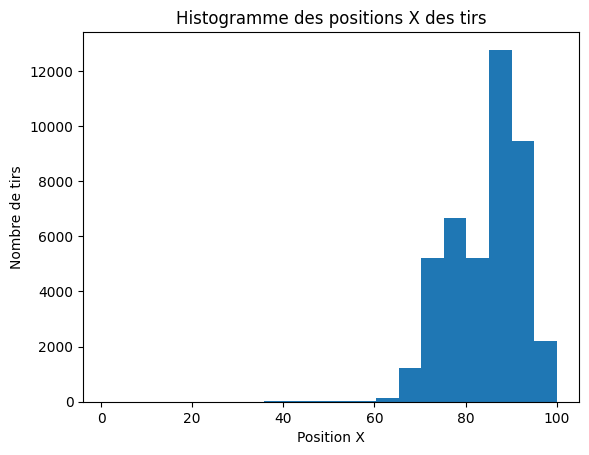

In [237]:
# Histogramme des positions X des tirs
# X représente la longueur du terrain malgré le fait que le terrain soit en 100x100

x_pos = shots["positions"].apply(lambda x: x[0]["x"])
plt.hist(x_pos, bins=20)
plt.title("Histogramme des positions X des tirs")
plt.xlabel("Position X")
plt.ylabel("Nombre de tirs")
#plt.ylim(0, 10)
plt.show()

On peut voir que tous les tirs sont effectuées dans la partie haute du terrain. Cependant, il est important de noter que les tirs ont été normalisés par rapport au sens du but. Ainsi, tous les tirs effectués dans le but adverse sont considérés comme des tirs dans la partie haute du terrain. On peut notamment le voir dans le graphique qui suit.

Text(0.5, 1.0, 'Positions des 1000 premiers tirs')

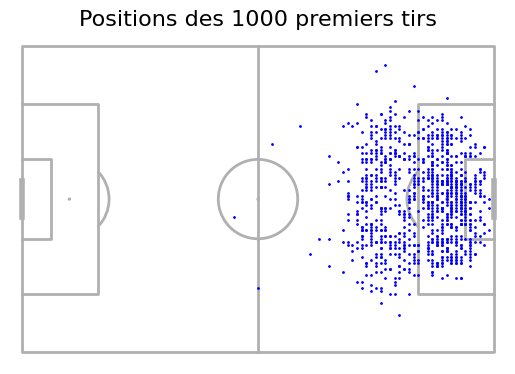

In [238]:
# Affichage des 1000 premibers tirs sur un terrain
# On peut voir qu'ils sont tous dans une seule moitié de terrain alors qu'un match se joue dans les deux sens
# Les données utilisées viennent de Wyscout

pitch = Pitch(pitch_type='wyscout')

fig, ax = pitch.draw(constrained_layout=True, tight_layout=False)

pitch.scatter(x_pos[:1000], shots["positions"].apply(lambda x: x[0]["y"])[:1000], ax=ax, s=1, color='blue')
ax.set_title("Positions des 1000 premiers tirs", fontsize=16)

# Transformation des données
Le but de la transformation de données est de convertir les positions X et Y en mètres. Suite à cela, nous allons pouvoir calculer la distance entre le tireur et le but adverse. Ensuite, nous allons également calculer l'angle de tir. Ces deux nouvelles caractéristiques vont nous permettre d'établir correctement un modèle d'expected goals.

In [239]:
# Taille du terrain
pitch_size = (105, 68)
# On transforme d'abord les positions des tirs correctements
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * pitch_size[0]/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * pitch_size[1]/100)
# Utile pour le calcul de la distance au but et de l'angle de tir
# L'attribut C est un équivalent de Y mais il permet de situer le but en position 0, 0
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * pitch_size[1]/100)
#print(shots[["X", "Y", "C"]].head())

In [240]:
# Les coordonnées du but sont (0, 50). On peut le voir sur le glossaire de Wyscout dans "Pitch Coordinates"
# Cependant, on a besoin de les transformer pour qu'elles soient dans le même format que les positions des tirs
# Pour rappel, la taille du terrain est de 105x68
# On choisit également le but en 0, 50 car cela nous permettra de calculer l'angle du tir par rapport au but
goal_coordinates = np.array([0*pitch_size[0]/100, 50*pitch_size[1]/100])
print(goal_coordinates)

# Largeur du but
goal_width = 7.32
# On calcule la distance entre le but et le tir avec la dimension 105x68
shots["distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)

# Calcul de l'angle avec la fonction utilisée et expliqué dans la thèse.
shots["angle"] = np.pi - \
                    (np.arctan( (shots["C"] - goal_width/2) / shots["X"]) + np.pi/2) - \
                    (np.pi/2 - np.arctan( (shots["C"] + goal_width/2) / shots["X"]))
# Angle en degré
shots["angle_deg"] = shots["angle"] * 180 / np.pi

shots["goal"] = shots["tags"].apply(lambda cell: 101 in [tag["id"] for tag in cell])

shots["header"] = shots["tags"].apply(lambda cell: 403 in [tag["id"] for tag in cell])

def extract_good_foot(tags):
    for tag in tags:
        if tag['id'] == 401:
            return 'left'
        elif tag['id'] == 402:
            return 'right'
    return None  # Retourne None si aucun pied correspondant n'est trouvé

shots["foot_used_on_shot"] = shots["tags"].apply(extract_good_foot)



[ 0. 34.]


# Fusion des datasets

In [241]:
# Le but de la fusion de dataset est de récupérer les informations des joueurs qui ont tiré
# Parmi ces informations on va récupérer le pied fort du joueur
# On va donc comparer si le pied fort du joueur est le même que le pied utilisé pour tirer

# On récupère les informations des joueurs qui ont tiré
shots = shots.merge(players[["wyId", "foot"]], left_on="playerId", right_on="wyId", how="inner")
# On calcule quel est le bon pied pour chaque tir
shots["good_foot_used"] = shots["foot"] == shots["foot_used_on_shot"]



In [242]:
# On prend uniquement les attributs qui nous intéressent
shots = shots[["X", "Y", "distance", "angle", "angle_deg", "goal", "header", "good_foot_used"]]

print(shots.head(5))

                        

       X      Y   distance     angle  angle_deg   goal  header  good_foot_used
0   6.30  38.76   7.896050  0.755576  43.291300   True   False            True
1  13.65  46.24  18.334124  0.300230  17.201926  False   False            True
2  29.40  40.80  30.176150  0.235417  13.488423  False   False            True
3  28.35  23.80  30.129097  0.227998  13.063307  False   False            True
4  12.60  29.92  13.244108  0.517537  29.652659  False   False           False


# Visualisation des données
## Description des données numériques

In [243]:
shots.describe()

,X,Y,distance,angle,angle_deg
count,43075.000000,43075.000000,43075.000000,43075.000000,43075.000000
mean,15.992225,33.473176,18.593067,0.414140,23.728497
std,8.534333,9.366171,8.419298,0.253173,14.505766
min,0.000000,0.000000,0.680000,0.000000,0.000000
25%,9.450000,26.520000,12.249445,0.250188,14.334692
50%,13.650000,33.320000,17.153297,0.327782,18.780499
75%,23.100000,40.800000,24.936000,0.505984,28.990776
max,103.950000,68.000000,103.952224,3.141593,180.000000


## Position de tous les tirs sous formes de heatmap

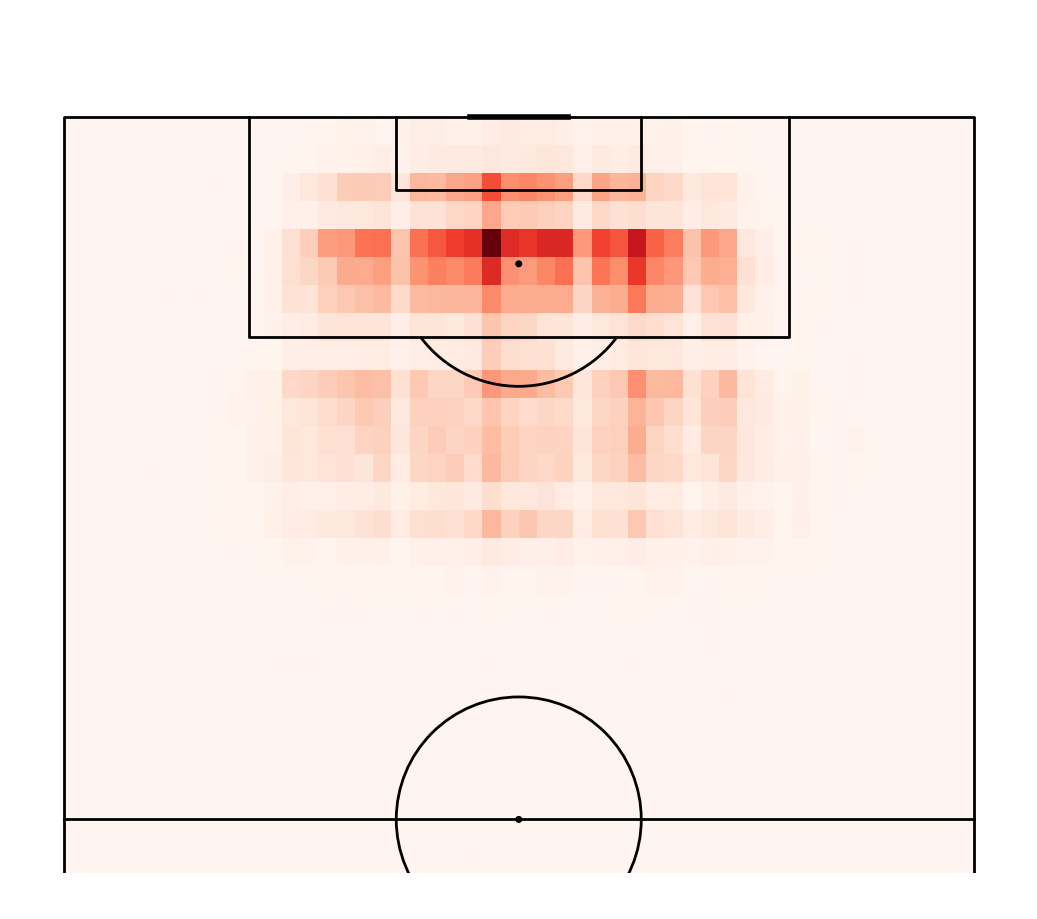

In [254]:
# Le but est d'afficher une moitié de terrain avec une heatmap qui montre la fréquence des positions des tirs

# On crée un terrain avec la librairie mplsoccer. La taille du terrain est de 105x68
# On doit obligatoirement mettre "line_zorder = 2" pour que le terrain soit affiché correctement sur la heatmap
pitch = VerticalPitch(line_color="black", pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2, half=True)

# Il faut mettre une grille sur le terrain pour pouvoir afficher la heatmap
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# On affiche la heatmap avec la fonction heatmap de la librairie mplsoccer
# On prépare les données avec la fonction bin_statistic qui permet de compter le nombre de tirs dans chaque case
# 105-shots.X car autrement les tirs sont affichés de l'autre côté du terrain
bin_statistics_shot = pitch.bin_statistic(105-shots.X, shots.Y, bins=(50, 50))
pitch.heatmap(bin_statistics_shot, ax=ax["pitch"], cmap='Reds', edgecolors='white', linewidth=0)


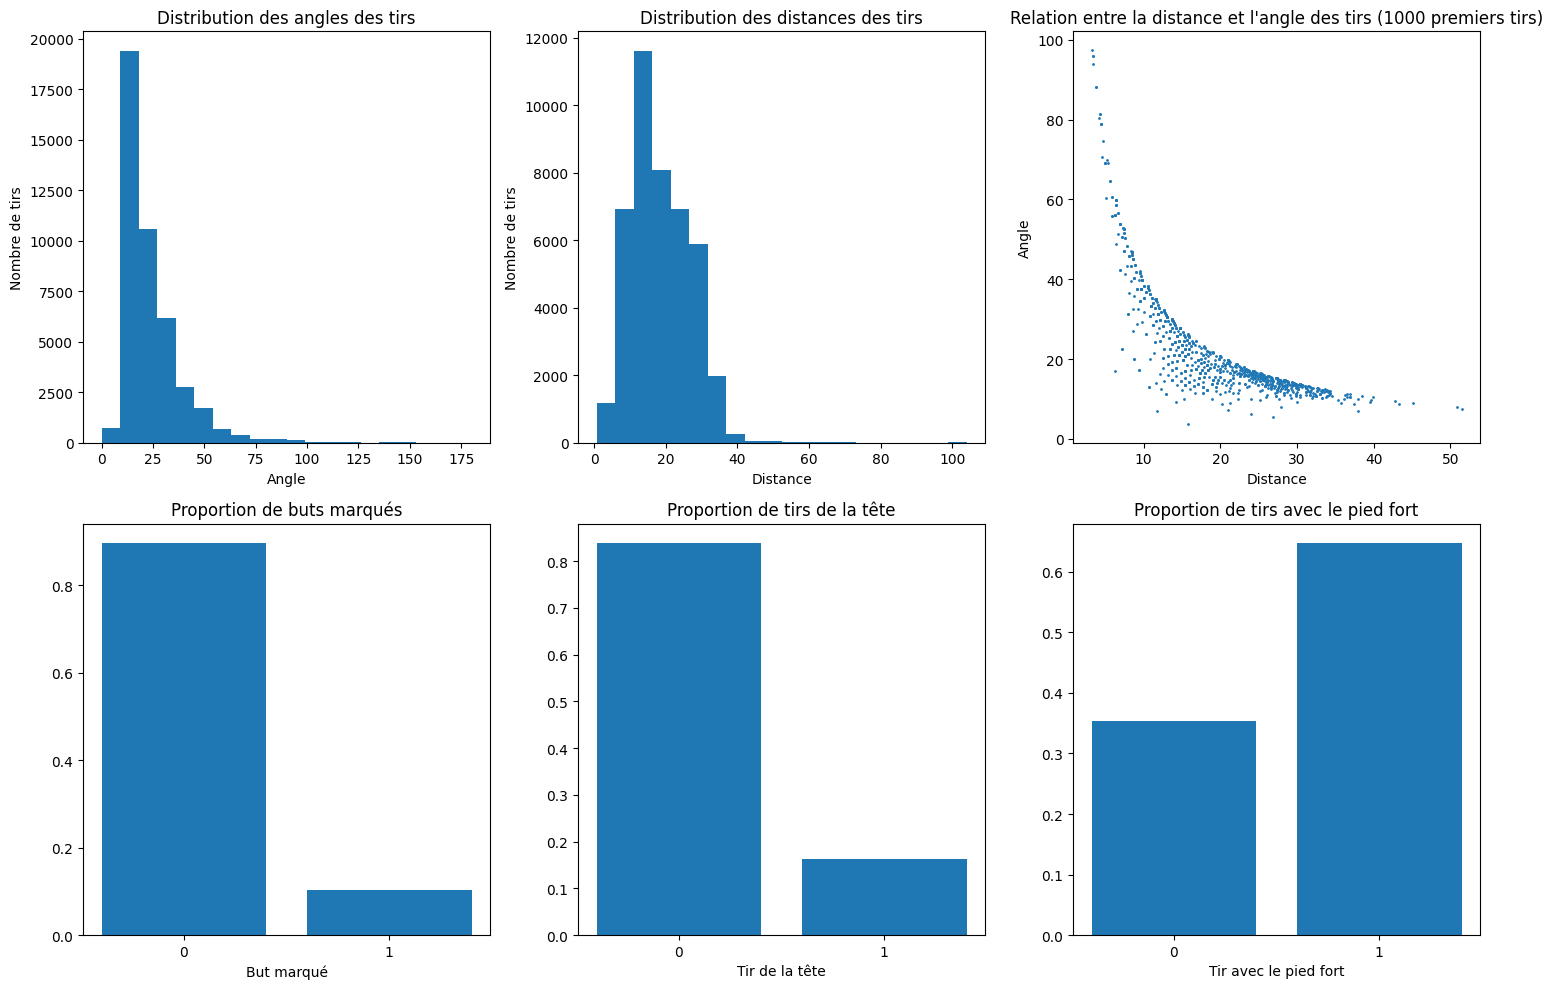

In [245]:
import matplotlib.pyplot as plt

# Créer un subplot avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Affichage de la distribution des angles des tirs via un histogramme
axes[0,0].hist(shots["angle_deg"], bins=20)
axes[0,0].set_xlabel("Angle")
axes[0,0].set_ylabel("Nombre de tirs")
axes[0,0].set_title("Distribution des angles des tirs")

# Affichage de la distribution de la distance des tirs via un histogramme
axes[0,1].hist(shots["distance"], bins=20)
axes[0,1].set_xlabel("Distance")
axes[0,1].set_ylabel("Nombre de tirs")
axes[0,1].set_title("Distribution des distances des tirs")

# Affichage de la relation entre la distance et l'angle des tirs
axes[0,2].scatter(shots["distance"][:1000], shots["angle_deg"][:1000], s=1)
axes[0,2].set_title("Relation entre la distance et l'angle des tirs (1000 premiers tirs)")
axes[0,2].set_xlabel("Distance")
axes[0,2].set_ylabel("Angle")

# Probabilité des buts marqué
category_counts = shots['goal'].value_counts(normalize=True)
# Créer le diagramme en barres
axes[1,0].bar(category_counts.index, category_counts.values)
axes[1,0].set_title("Proportion de buts marqués")
axes[1,0].set_xlabel("But marqué")
axes[1,0].set_xticks([0, 1])

# Probabilité des tirs de la tête
category_counts = shots['header'].value_counts(normalize=True)
# Créer le diagramme en barres
axes[1,1].bar(category_counts.index, category_counts.values)
axes[1,1].set_title("Proportion de tirs de la tête")
axes[1,1].set_xlabel("Tir de la tête")
axes[1,1].set_xticks([0, 1])

# Probabilité des tirs avec le pied fort
category_counts = shots['good_foot_used'].value_counts(normalize=True)
# Créer le diagramme en barres
axes[1,2].bar(category_counts.index, category_counts.values)
axes[1,2].set_title("Proportion de tirs avec le pied fort")
axes[1,2].set_xlabel("Tir avec le pied fort")
axes[1,2].set_xticks([0, 1])

plt.tight_layout()

# Afficher le subplot
plt.show()

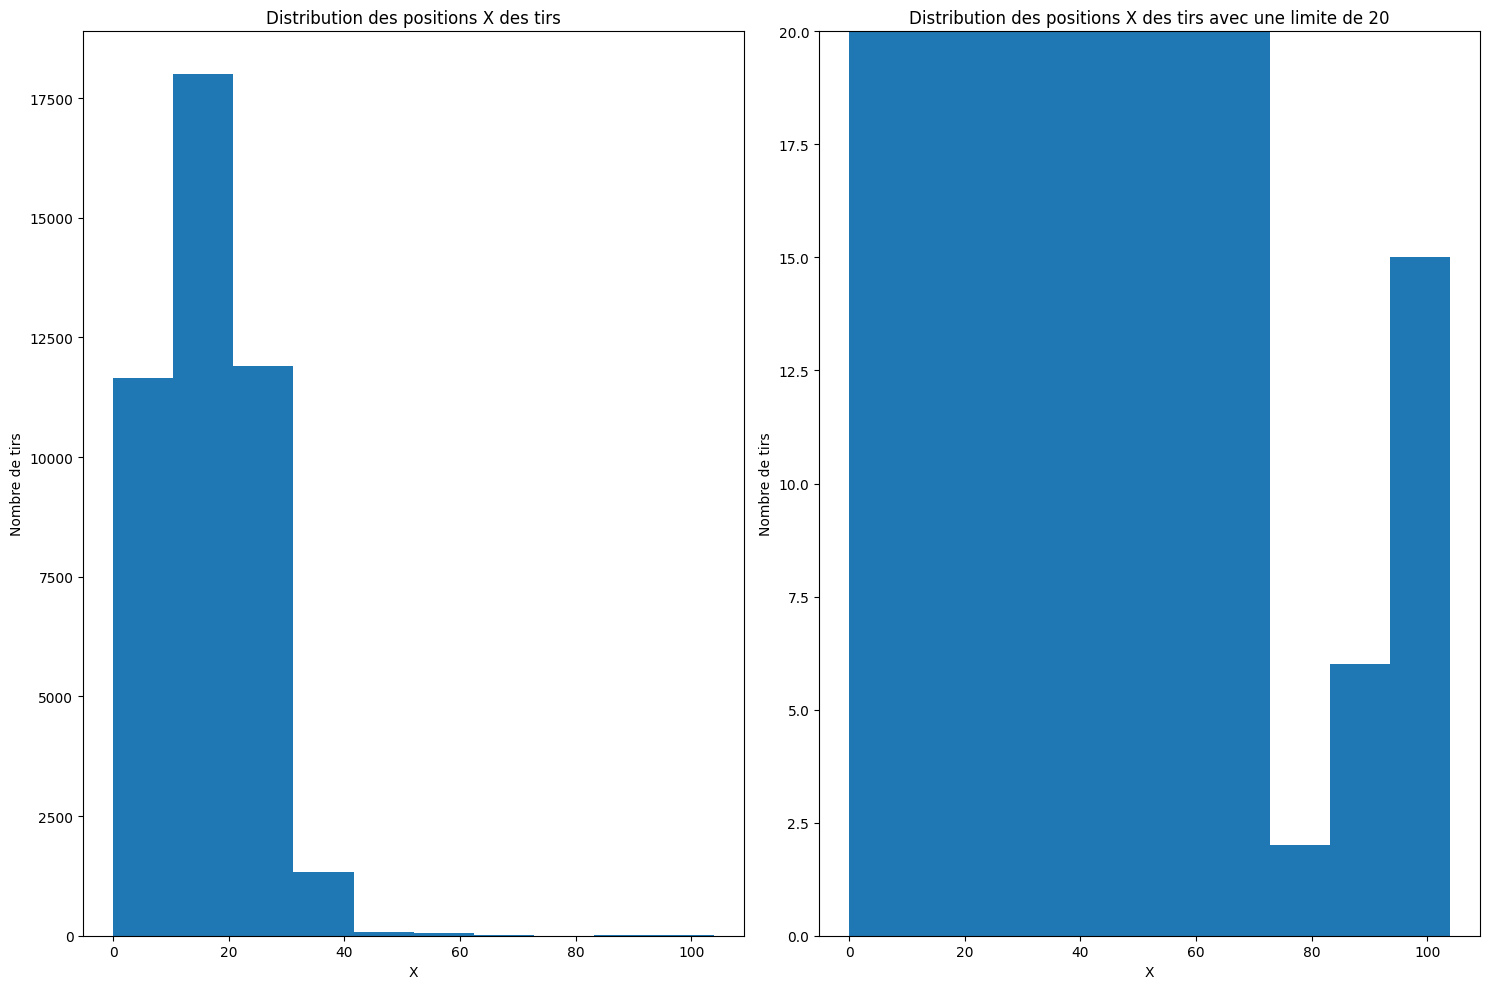

In [246]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].hist(shots["X"])
axes[0].set_xlabel("X")
axes[0].set_ylabel("Nombre de tirs")
axes[0].set_title("Distribution des positions X des tirs")

axes[1].hist(shots["X"])
axes[1].set_xlabel("X")
axes[1].set_ylabel("Nombre de tirs")
axes[1].set_title("Distribution des positions X des tirs avec une limite de 20")
axes[1].set_ylim(0, 20)

# Permet de voir les deux graphiques en même temps
# Le deuxième graphique permet qu'une minorité de 
# tirs a été effectué à l'opposé du terrain

plt.tight_layout()

# Afficher le subplot
plt.show()